<a href="https://colab.research.google.com/github/saidanaam/Web_scarping_NLP_KG/blob/main/Web_scraping_analyse_par_NLP_et_construction_d%E2%80%99un_graphe_de_connaissance_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# installer API de wikipédia
!pip install wikipedia-api

**importation des bibliothéques**

In [ ]:
import wikipediaapi
import pandas as pd
import concurrent.futures
from tqdm import tqdm
import nltk
import spacy
from spacy.matcher import Matcher
from spacy.tokens import Span
import re
from nltk.stem.porter import PorterStemmer
import networkx as nx
import matplotlib.pyplot as plt


In [ ]:
nlp = spacy.load('en_core_web_sm')

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

**1.   Web scraping : en utilisant API de wikipédia**

In [ ]:
def scrap_sentence(topic, verbose=True):
    # Définition d'une fonction interne pour traiter chaque lien Wikipedia
    def link_to_wikipedia(link):
        try:
            # Récupération de la page Wikipedia pour un lien donné
            page = api_wikipedia.page(link)
            if page.exists():
                # Extraction des phrases du texte de la page et prise de la première phrase
                sentences = nltk.sent_tokenize(page.text)
                return {
                    'page': link,
                    'sentence': sentences[0] if sentences else None,  # Première phrase ou None si aucune phrase
                    'link': page.fullurl,
                    'categories': list(page.categories.keys())
                }
        except Exception as e:
            print("Exception occurred:", e)
            return None

    # Création de l'objet Wikipedia avec un User-Agent personnalisé
    api_wikipedia = wikipediaapi.Wikipedia(
        language='en',
        extract_format=wikipediaapi.ExtractFormat.WIKI,
        user_agent='Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.182 Safari/537.36'
    )

    # Récupération de la page principale pour le sujet donné
    name_of_page = api_wikipedia.page(topic)
    if not name_of_page.exists():
        print('Page {} is not present'.format(topic))
        return
    else:
        # Récupération des liens présents sur la page principale
        links_to_page = list(name_of_page.links.keys())
        # Initialisation de la barre de progression si verbose est True
        proceed = tqdm(desc='Scraped links', unit='', total=len(links_to_page)) if verbose else None
        # Initialisation de la liste des informations avec la page principale
        infos = [{
            'page': topic,
            'sentence': nltk.sent_tokenize(name_of_page.text)[0],
            'link': name_of_page.fullurl,
            'categories': list(name_of_page.categories.keys())
        }]

    # Utilisation d'un ThreadPoolExecutor pour traiter les liens en parallèle
    with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
        # Soumission des tâches pour chaque lien
        links_future = {executor.submit(link_to_wikipedia, link): link for link in links_to_page}
        for future in concurrent.futures.as_completed(links_future):
            # Récupération du résultat de chaque tâche terminée
            info = future.result()
            # Ajout des informations récupérées à la liste si elles existent
            infos.append(info) if info else None
            # Mise à jour de la barre de progression si verbose est True
            proceed.update(1) if verbose else None
    if verbose:
        # Fermeture de la barre de progression
        proceed.close()

    # Filtrage des résultats pour exclure certains espaces de noms
    namespaces = ('Wikipedia', 'Special', 'Talk', 'LyricWiki', 'File', 'MediaWiki', 'Template', 'Help', 'User', 'Category talk', 'Portal talk')
    infos = pd.DataFrame(infos)
    infos = infos[(~infos['sentence'].isnull()) & ~(infos['page'].str.startswith(namespaces, na=True))]
    # Nettoyage des catégories pour chaque page
    infos['categories'] = infos.categories.apply(lambda a: [b[9:] for b in a])

    # Ajout du sujet aux informations
    infos['topic'] = topic
    # Affichage du nombre de pages extraites
    print('Scraped pages', len(infos))

    # Retour des informations extraites
    return infos

In [ ]:
# entrer un sujet quelconque pour collecter des données liées a ce projet
data_sentence = scrap_sentence('Artificial Intelligence')

Scraped links: 100%|██████████| 1668/1668 [06:14<00:00,  4.45/s]

Scraped pages 1609




**2.   Praitrétement des données**




In [ ]:
def preprocessing(text):
    text = re.sub(r"[,.\"!@#$%^&*(){}?/;`~:<>+=-]","", text)
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    emoji = re.compile("["
                           u"\U0001F600-\U0001FFFF"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji.sub(r'', text)
    doc = nlp(text)
    filtered_text = []
    #stemmer = PorterStemmer()
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        lemma = token.lemma_
        #stemmed = stemmer.stem(token.text)
        filtered_text.append(lemma )#if lemma != token.text else stemmed)
    return " ".join(filtered_text)

In [ ]:
data_sentence['prep_sentence'] = data_sentence['sentence'].apply(preprocessing)

**3. Extraction des entités**

In [ ]:
def extraction_entities(text):
    # Initialisation des variables pour le sujet et l'objet
    sujet = ""
    objet = ""

    # Variables pour stocker la dépendance et le texte du token précédent
    prv_tok_dep = ""
    prv_tok_text = ""

    # Préfixe pour construire les entités composées
    prefix = ""

    # Boucle sur chaque token du texte analysé par le modèle NLP
    for token in nlp(text):
        # Ignorer les tokens de ponctuation
        if token.dep_ != "punct":
            # Vérifier si le token est une partie d'un nom composé ou modifie un nom
            if token.dep_ == "compound" or token.dep_.endswith("mod") or token.dep_ == "attr":
                prefix = token.text

                # Si le token précédent est aussi une partie d'un nom composé ou modifie un nom, les combiner
                if prv_tok_dep == "compound" or prv_tok_dep.endswith("mod") or prv_tok_dep == "attr":
                    prefix = prv_tok_text + " " + token.text

            # Vérifier si le token est un sujet
            if token.dep_.find("subj") == True:
                sujet = prefix + " " + token.text
                prefix = ""
                prv_tok_dep = ""
                prv_tok_text = ""

            # Vérifier si le token est un objet
            if token.dep_.find("obj") == True:
                objet = prefix + " " + token.text
            else:
                # Parfois, le token avec dépendance 'attr' est l'objet
                objet = prefix

            # Mettre à jour les variables pour le prochain tour de boucle
            prv_tok_dep = token.dep_
            prv_tok_text = token.text

    # Retourner les entités sujet et objet après avoir enlevé les espaces superflus
    return [sujet.strip(), objet.strip()]

In [ ]:
pair_entity = []
for i in tqdm(data_sentence['prep_sentence']):
    pair_entity.append(extraction_entities(i))

100%|██████████| 1609/1609 [00:15<00:00, 105.54it/s]


**`4`**. **Extraction des relations**

In [ ]:
def extract_relation(text):
    # Analyse le texte avec le modèle NLP
    doc = nlp(text)

    # Initialise un objet Matcher avec le vocabulaire du modèle NLP
    matcher = Matcher(nlp.vocab)

    # Définition d'un motif (pattern) pour le matcher
    pattern = [
        {'DEP': 'ROOT'},          # La racine de la phrase (verbe principal)
        {'DEP': 'prep', 'OP': "?"},  # Une préposition facultative
        {'DEP': 'agent', 'OP': "?"}, # Un agent facultatif (comme dans une voix passive)
        {'POS': 'ADJ', 'OP': "?"}    # Un adjectif facultatif
    ]

    # Ajout du motif au matcher avec le nom "matching_1"
    matcher.add("matching_1", [pattern])

    # Applique le matcher au document analysé
    matches = matcher(doc)

    # Sélectionne le dernier match trouvé
    k = len(matches) - 1
    span = doc[matches[k][1]:matches[k][2]]

    # Retourne le texte du span correspondant au dernier match
    return span.text

In [ ]:
Relations = [extract_relation(i) for i in tqdm(data_sentence['prep_sentence'])]
source = [i[0] for i in pair_entity]
target = [i[1] for i in pair_entity]

100%|██████████| 1609/1609 [00:15<00:00, 103.17it/s]


In [ ]:
data_KG = pd.DataFrame({'Source': source, 'Target':target, 'Edges':Relations})
data_KG.sample(20)

,Source,Target,Edges
367,David Berlinski,american mathematician philosopher,bear
1408,,1983 1993,government
1503,improve,type biological tissue,maintain
860,,factory automation,system
834,James Gleick,impact modern technology,bear
268,mathematics,usage relate class,classify computational
334,statistical analysis,independent datum set,generalize independent
1521,insufficient determine belief,response,datum abbreviate
162,postulate assumption statement,point reasoning argument,take true
372,deidentification process,personal identity reveal,prevent personal


In [ ]:
data_KG['Edges'].value_counts()

Edges
bear                 80
know                 44
develop              37
learn                31
include              22
                     ..
summarise single      1
success               1
flight                1
express dynamical     1
control sensory       1
Name: count, Length: 923, dtype: int64

In [ ]:
# on va supprimer les valeurs monquants
data_KG.replace('', None, inplace=True)
data_KG.isnull().sum()

Source    410
Target     37
Edges       0
dtype: int64

In [ ]:
data_KG.dropna(inplace=True)
data_KG.sample(10)

,Source,Target,Edges
1221,individual domain discourse,satisfy open formula,specify individual
252,cluster analysis,group cluster,set
765,2023 canadian philosopher,philosophy science,specialize
1083,nohm CHOMskee,social criticism,bear
1129,Patricia Smith Churchland,neurophilosophy philosophy mind,bear
1428,multiple robot system,simple physical robot,consist large
1503,improve,type biological tissue,maintain
399,descriptive research,population phenomenon study,describe characteristic
1212,mind psychophysical parallelism,coordinated causal interaction,theory mental
725,story rumor artificial,consciousness master craftsman,begin




1.   **Visualisation et construction du graphe**



<function matplotlib.pyplot.show(close=None, block=None)>

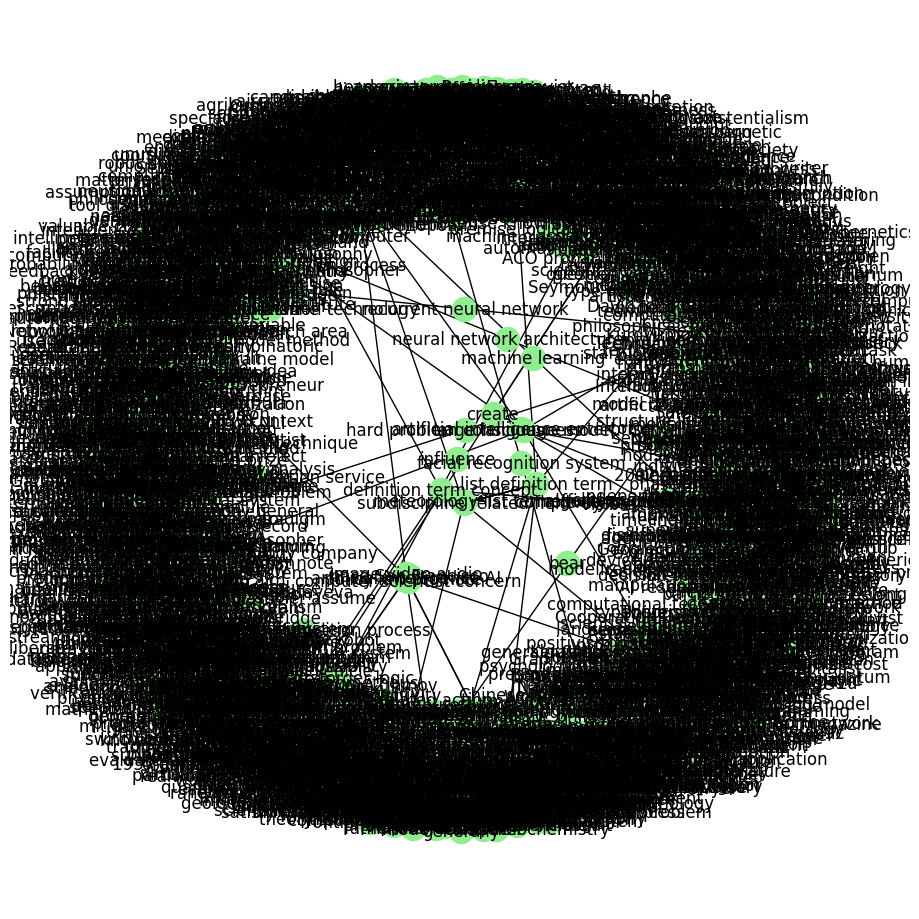

In [ ]:
#construire la KG
KG_AI = nx.from_pandas_edgelist(data_KG, source="Source", target="Target", edge_attr=True, create_using= nx.MultiDiGraph())
#plot KG
plt.figure(figsize=(9,9))
pos = nx.spring_layout(KG_AI)
nx.draw(KG_AI, with_labels=True, node_color = 'lightgreen', edge_cmap = plt.cm.Blues, pos=pos )
plt.show